# use mtcnn for testing

In [9]:
from __future__ import print_function

import os
os.environ['GLOG_minloglevel'] = '2'  # Hide caffe debug info.
import sys
import math
import time

import cv2
import caffe

import numpy as np
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline


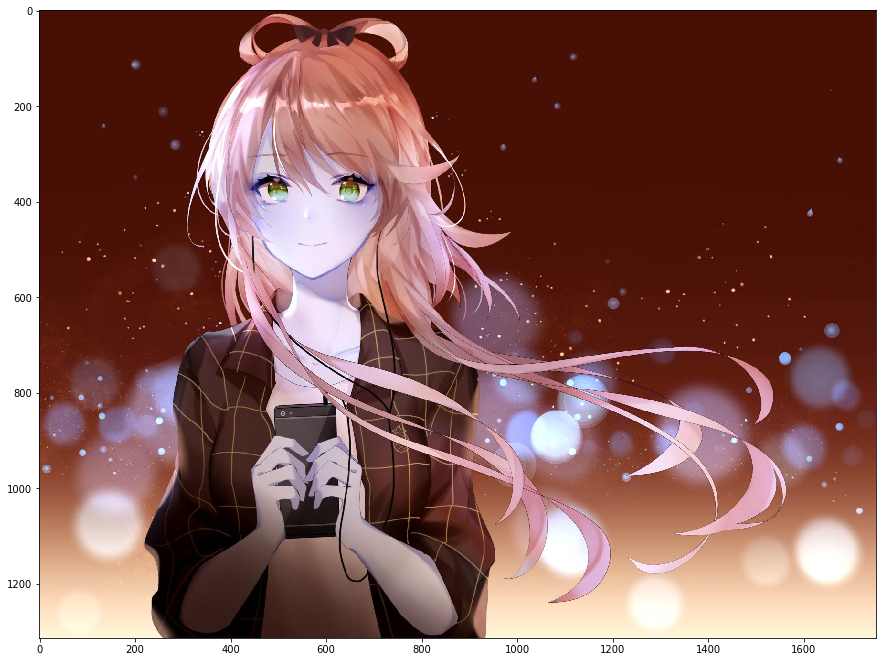

Image shape: (1753, 1314, 3)
Resize to: (877, 657, 3)
Resize to: (622, 466, 3)
Resize to: (441, 331, 3)
Resize to: (313, 235, 3)
Resize to: (222, 167, 3)
Resize to: (158, 118, 3)
Resize to: (112, 84, 3)
Resize to: (79, 60, 3)
Resize to: (56, 42, 3)
Resize to: (40, 30, 3)
Resize to: (29, 22, 3)
Resize to: (20, 15, 3)
After PNet bboxes shape:  (175, 5)
After RNet bboxes shape:  (35, 5)
After ONet bboxes shape:  (5, 5) 

Total time: 0.928s

Rect: 1138 896 1165 930
Rect: 1112 670 1135 699
Rect: 448 881 620 1093
Rect: 1195 876 1236 928
Rect: 1556 871 1625 957


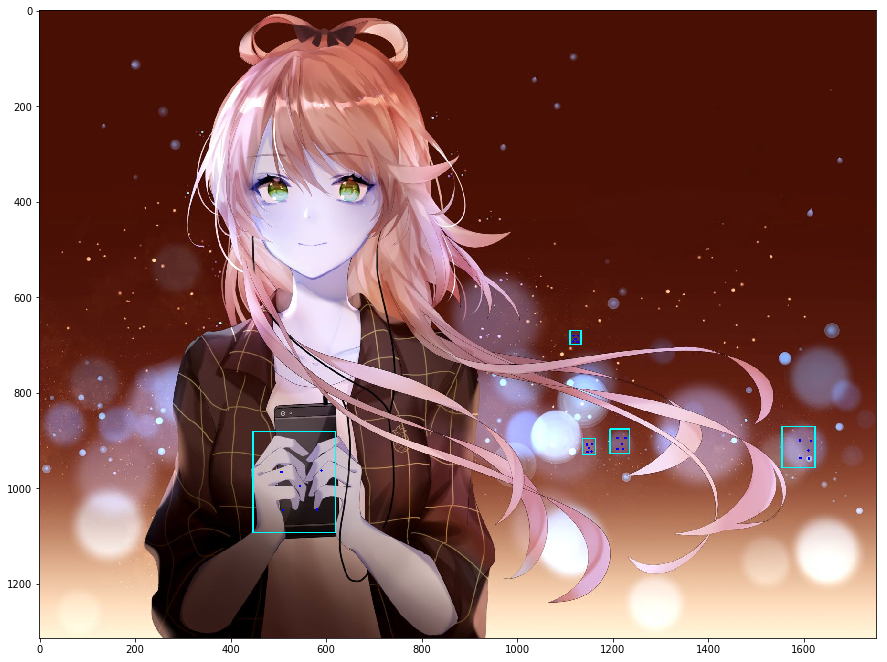

In [22]:
import os
caffe.set_mode_gpu()
caffe.set_device(0)

os.chdir('/xuan/mtcnn')

image_path =  "/xuan/tutorial/catonTest.jpg"
im = cv2.imread(image_path)
assert im is not None, 'Image is empty.'

im_bk = im.copy()
plt.figure(figsize=(15,15))
plt.imshow(im_bk)
plt.show()


im = im.astype(np.float32)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = np.transpose(im, (1,0,2))  # Rotate image.

image_height, image_width, num_channels = im.shape
print('Image shape:', im.shape)

assert num_channels == 3, 'Error: only support RGB image.'

MIN_FACE_SIZE = 24.    # Minimum face size.
MIN_INPUT_SIZE = 12.   # Minimum input size.
m = MIN_INPUT_SIZE / MIN_FACE_SIZE

min_size = min(image_height, image_width)
min_size = min_size * m

scales = []
counter = 0
FACTOR = 0.709
while min_size >= MIN_INPUT_SIZE:
    scales.append(m * FACTOR**counter)
    min_size = min_size * FACTOR
    counter = counter + 1

# Load models.
prototxt = ['./model/' + x + '.prototxt' for x in ['det1', 'det2', 'det3']]
binary = ['./model/' + x + '.caffemodel' for x in ['det1', 'det2', 'det3']]
PNet = caffe.Net(prototxt[0], binary[0], caffe.TEST)
RNet = caffe.Net(prototxt[1], binary[1], caffe.TEST)
ONet = caffe.Net(prototxt[2], binary[2], caffe.TEST)

# Threshold for each stage.
# THRESHOLD = [0.6, 0.7, 0.7]

THRESHOLD = [0.6, 0.4, 0.4]

t1 = time.time()

# --------------------------------------------------------------
# First stage.
#
total_boxes = []  # Bounding boxes of all scales.
for scale in scales:
    hs = int(math.ceil(image_height*scale))
    ws = int(math.ceil(image_width*scale))

    im_resized = cv2.resize(im, (ws,hs), interpolation=cv2.INTER_AREA)
    print('Resize to:', im_resized.shape)

    # H,W,C -> C,H,W
    im_resized = np.transpose(im_resized, (2,0,1))

    # Zero mean and normalization.
    im_resized = (im_resized - 127.5) * 0.0078125

    # Reshape input layer.
    PNet.blobs['data'].reshape(1, 3, hs, ws)
    PNet.blobs['data'].data[...] = im_resized
    outputs = PNet.forward()

    bboxes = get_pnet_boxes(outputs, scale, THRESHOLD[0])
    bboxes,_ = non_max_suppression(bboxes, 0.5)

    total_boxes.append(bboxes)

total_boxes = np.vstack(total_boxes)

bboxes,_ = non_max_suppression(total_boxes, 0.7)
bboxes = bbox_regression(total_boxes)

bboxes = bbox_to_square(bboxes)
bboxes = padding(bboxes, image_height, image_width)

print('After PNet bboxes shape: ', bboxes.shape)

# --------------------------------------------------------------
# Second stage.
#
inputs = get_inputs_from_bboxes(im, bboxes, 24)
N,C,H,W = inputs.shape

RNet.blobs['data'].reshape(N,3,H,W)
RNet.blobs['data'].data[...] = inputs
outputs = RNet.forward()

bboxes = get_rnet_boxes(bboxes, outputs, THRESHOLD[1])

bboxes,_ = non_max_suppression(bboxes, 0.7)
bboxes = bbox_regression(bboxes)
bboxes = bbox_to_square(bboxes)
bboxes = padding(bboxes, image_height, image_width)

print('After RNet bboxes shape: ', bboxes.shape)


# --------------------------------------------------------------
# Third stage.
#
inputs = get_inputs_from_bboxes(im, bboxes, 48)
N,C,H,W = inputs.shape

ONet.blobs['data'].reshape(N,3,H,W)
ONet.blobs['data'].data[...] = inputs
outputs = ONet.forward()

bboxes, points = get_onet_boxes(bboxes, outputs, THRESHOLD[2])
bboxes = bbox_regression(bboxes)

bboxes, picked_indices = non_max_suppression(bboxes, 0.7, 'min')
points = points[picked_indices]
bboxes = padding(bboxes, image_height, image_width)

print('After ONet bboxes shape: ', bboxes.shape, '\n')


t2 = time.time()
print('Total time: %.3fs\n' % (t2-t1))

num_boxes = bboxes.shape[0]
for i in range(num_boxes):
    box = bboxes[i]
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])
    print('Rect:', y1, x1, y2, x2)
    # As im is rotated, so need to swap x and y.
    cv2.rectangle(im_bk, (y1,x1), (y2,x2), (0,255,255), 2)

    if points.size:
        p = points[i]
        for i in range(5):
            x = int(p[i])
            y = int(p[i+5])
            # Again, swap x and y.
            cv2.circle(im_bk, (y,x), 1, (0,0,255), 2)
plt.figure(figsize=(15,15))
plt.imshow(im_bk)